In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import pickle
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [3]:
Xd =  pickle.load(open('./drive/MyDrive/RML2016.10a_dict.pkl','rb'), encoding='latin1')
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):
          lbl.append((mod,snr))
X = np.vstack(X)

In [4]:
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
# Partition the data
#  into training and test sets of the form we can train/test on
#  while keeping SNR and Mod labels handy for each
n_examples = X.shape[0]
n_train = int(n_examples * 0.5)

train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]

def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1

Y_train = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), train_idx)))
Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))

in_shp = list(X_train.shape[1:])
print(X_train.shape, in_shp)
classes = mods
print(X_test.shape)

(110000, 2, 128) [2, 128]
(110000, 2, 128)


# Build the NN Model

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [7]:
nb_epoch = 100     # number of epochs to train on
batch_size = 1024  # training batch size
num_classes = 11

In [10]:
# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train).float().to(device).view(-1, 1, *in_shp)
Y_train_tensor = torch.tensor(Y_train).float().to(device)
X_test_tensor = torch.tensor(X_test).float().to(device).view(-1, 1, *in_shp)
Y_test_tensor = torch.tensor(Y_test).float().to(device)


# Define dataset and data loader
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [35]:
class VT_CNN2(nn.Module):
    def __init__(
        self,
        n_classes: int = 11,
        dropout: float = 0.5,
        device: str = "cuda" if torch.cuda.is_available() else "cpu",
    ):
        super(VT_CNN2, self).__init__()

        self.device = device
        self.loss = nn.CrossEntropyLoss()

        self.model = nn.Sequential(
            nn.ZeroPad2d(
                padding=(
                    2,
                    2,
                    0,
                    0,
                )
            ),  # zero pad front/back of each signal by 2
            nn.Conv2d(
                in_channels=1, out_channels=256, kernel_size=(1, 3), stride=1, padding=0, bias=False
            ),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.ZeroPad2d(
                padding=(
                    2,
                    2,
                    0,
                    0,
                )
            ),  # zero pad front/back of each signal by 2
            nn.Conv2d(
                in_channels=256,
                out_channels=80,
                kernel_size=(2, 3),
                stride=1,
                padding=0,
            ),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Flatten(),
            nn.Linear(in_features=10560, out_features=256, bias=True),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=256, out_features=n_classes, bias=True),
        )

    def forward(self, x):
        return self.model(x)

In [36]:
model = VT_CNN2().to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Print model summary
print(model)

learnable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of Learnable Parameters: {learnable_params}')

VT_CNN2(
  (loss): CrossEntropyLoss()
  (model): Sequential(
    (0): ZeroPad2d((2, 2, 0, 0))
    (1): Conv2d(1, 256, kernel_size=(1, 3), stride=(1, 1), bias=False)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): ZeroPad2d((2, 2, 0, 0))
    (5): Conv2d(256, 80, kernel_size=(2, 3), stride=(1, 1))
    (6): ReLU()
    (7): Dropout(p=0.5, inplace=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=10560, out_features=256, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=256, out_features=11, bias=True)
  )
)
Number of Learnable Parameters: 2830171


In [ ]:
best_loss = float('inf')
patience = 10
early_stopping_counter = 0
filepath = './drive/MyDrive/vtcnn2.pt'

for epoch in range(nb_epoch):
    model.train()
    train_total_loss = 0
    for X_batch, Y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, Y_batch)
        loss.backward()
        optimizer.step()
        train_total_loss += loss.item()

    avg_train_loss = train_total_loss / len(train_loader)

    model.eval()
    total_loss = 0
    with torch.no_grad():
        for X_batch, Y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, Y_batch)
            total_loss += loss.item()

    avg_loss = total_loss / len(test_loader)
    print(f'Epoch {epoch+1}/{nb_epoch}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_loss:.4f}')

    # Checkpointing
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), filepath)
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print("Early stopping")
            break

# Load the best weights once training is finished
model.load_state_dict(torch.load(filepath))

In [17]:
model.eval()  # Set model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # Disable gradient calculation
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predicted = torch.argmax(outputs, dim=1)
        actual = torch.argmax(labels, dim=1)
        total += labels.size(0)
        correct += (predicted == actual).sum().item()

accuracy = correct / total
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 58.73%


In [19]:
idx = [i for i in range(len(X))]
Y =  to_onehot(list(map(lambda x: mods.index(lbl[x][0]), idx)))
test_SNRs = list(map(lambda x: lbl[x][1], idx))
X_16dB_test = X[np.where(np.array(test_SNRs)==16)]
Y_16dB_test = Y[np.where(np.array(test_SNRs)==16)]

In [21]:
N_test = X_16dB_test.shape[0]
print(X_16dB_test.shape)
X_16dB_test  = X_16dB_test.reshape(N_test, 2, 128, 1)

(11000, 2, 128)


In [29]:
X_16dB_test_tensor = torch.tensor(X_16dB_test).float().to(device).view(-1, 1, *in_shp)
predictions_16dB = model(X_16dB_test_tensor).cpu().detach().numpy()
accuracy_16dB = np.sum(np.argmax(predictions_16dB, axis=1) == np.argmax(Y_16dB_test, axis=1)) / len(Y_16dB_test)
print("Accuracy on benign test examples: {}%".format(accuracy_16dB * 100))

Accuracy on benign test examples: 81.61818181818182%


In [23]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

SNR: -20, Overall Accuracy: 14.233775677149609%
SNR: -18, Overall Accuracy: 15.787591632397639%
SNR: -16, Overall Accuracy: 15.752180232558139%
SNR: -14, Overall Accuracy: 20.183654729109275%
SNR: -12, Overall Accuracy: 24.2451967063129%
SNR: -10, Overall Accuracy: 33.59002566923359%
SNR: -8, Overall Accuracy: 45.133394664213434%
SNR: -6, Overall Accuracy: 56.44720043771658%
SNR: -4, Overall Accuracy: 63.317125877903834%
SNR: -2, Overall Accuracy: 73.4841461153347%
SNR: 0, Overall Accuracy: 78.99584612606104%
SNR: 2, Overall Accuracy: 78.99251688264282%
SNR: 4, Overall Accuracy: 80.5793991416309%
SNR: 6, Overall Accuracy: 81.58369408369408%
SNR: 8, Overall Accuracy: 81.91835260115607%
SNR: 10, Overall Accuracy: 82.15767634854772%
SNR: 12, Overall Accuracy: 81.79686090564677%
SNR: 14, Overall Accuracy: 81.89179241810821%
SNR: 16, Overall Accuracy: 80.96272167933405%
SNR: 18, Overall Accuracy: 82.84926470588235%


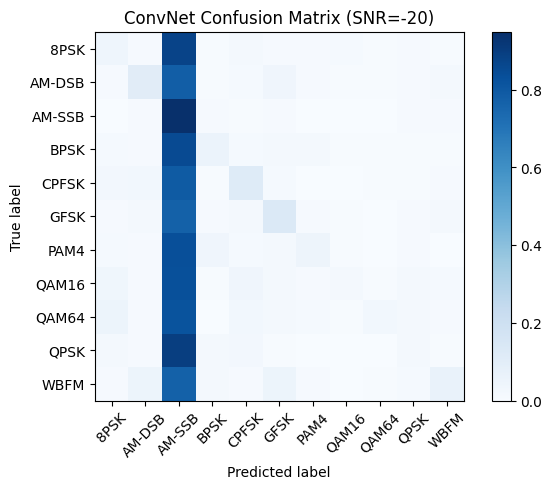

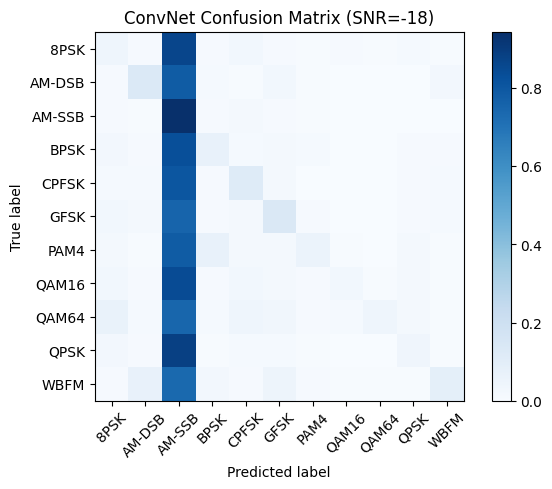

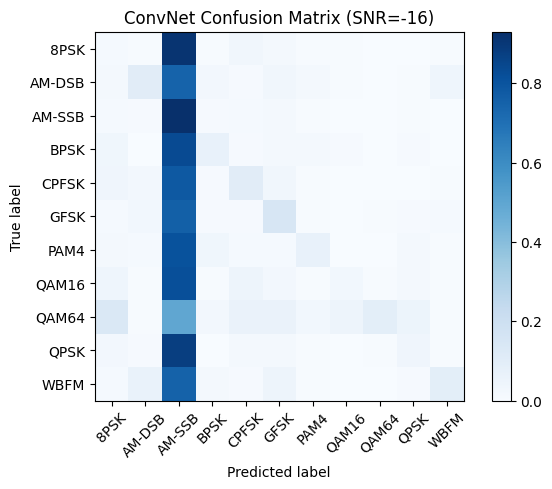

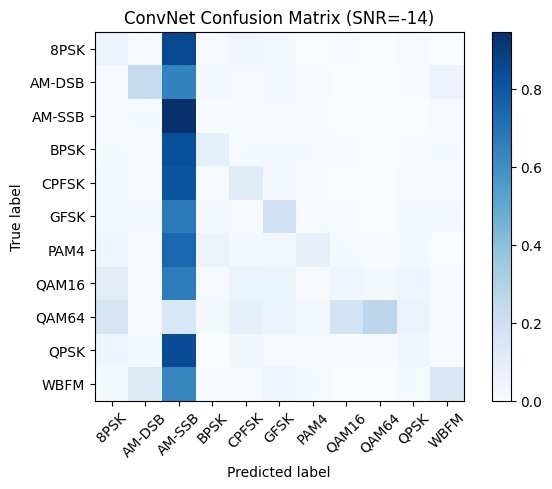

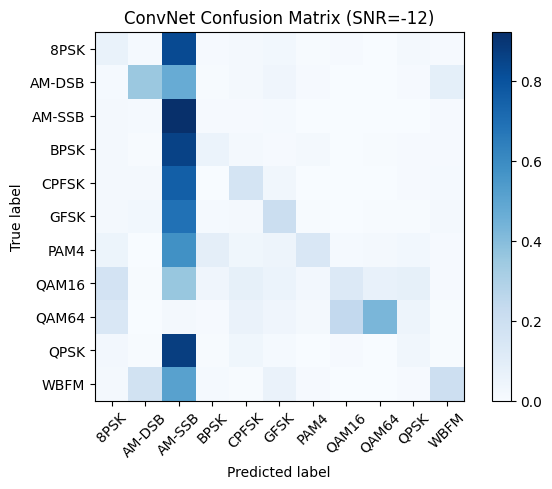

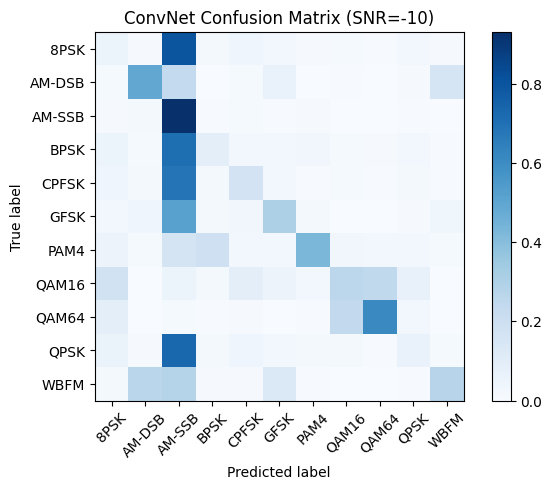

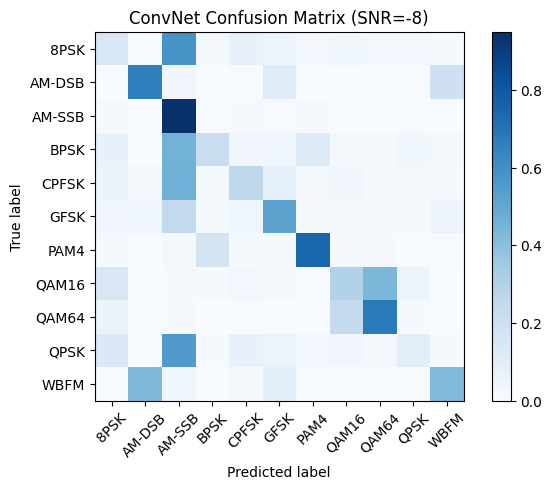

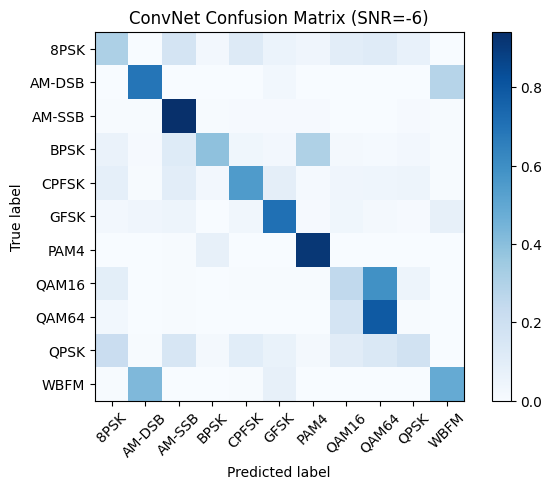

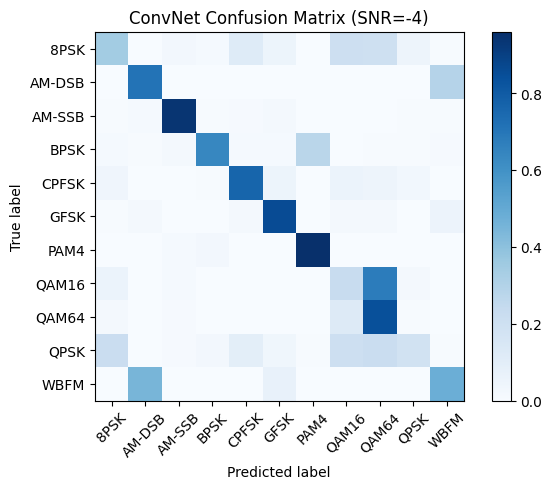

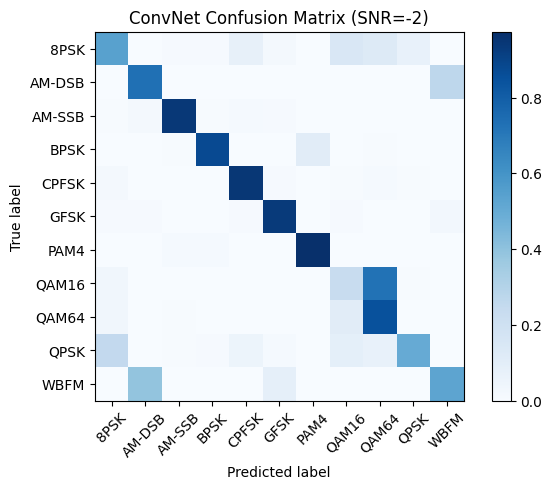

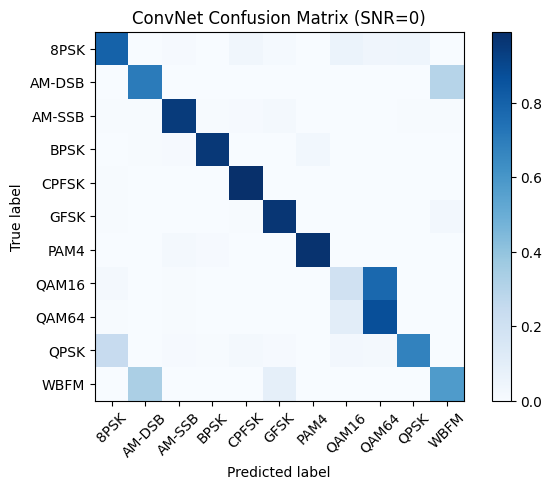

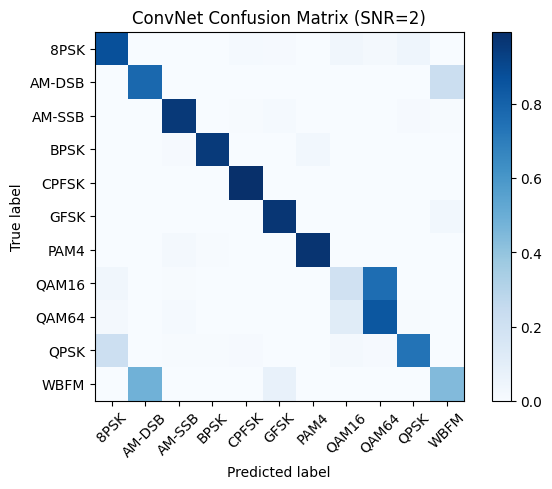

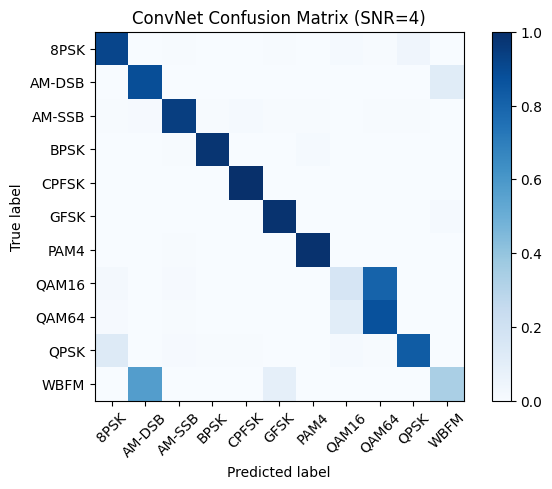

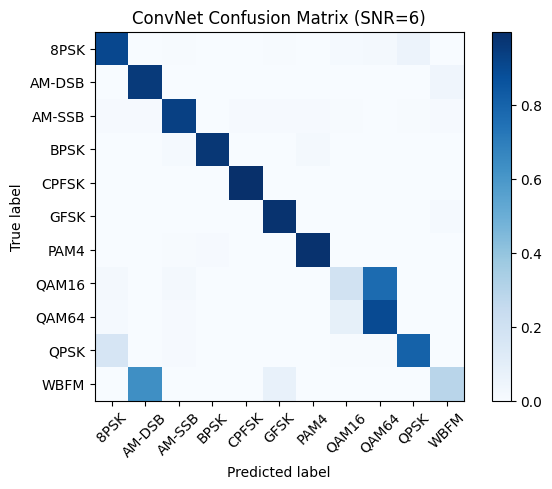

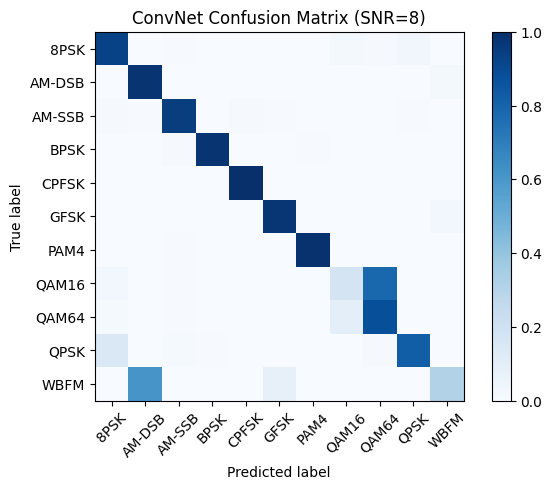

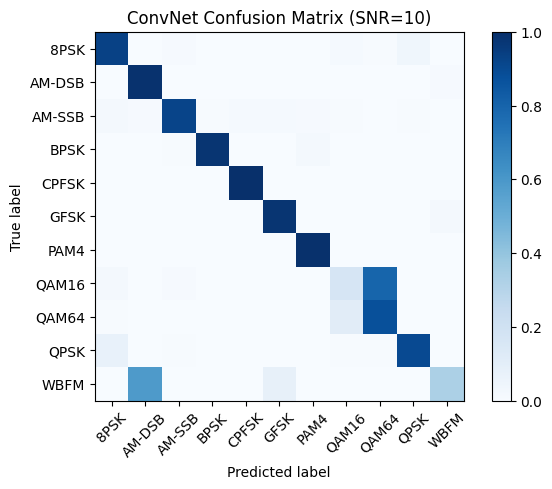

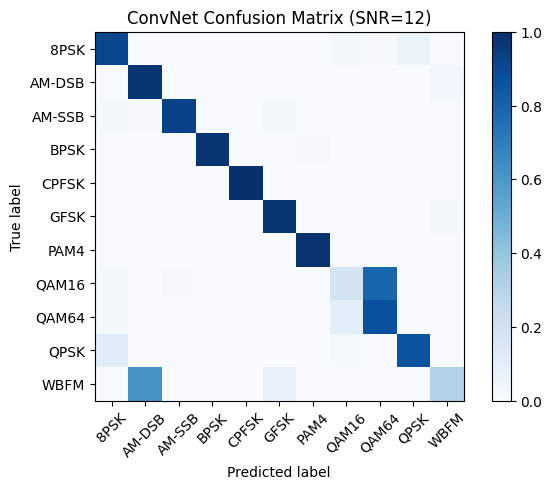

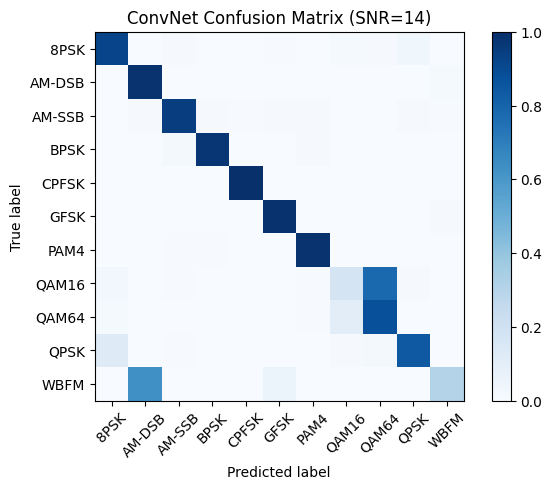

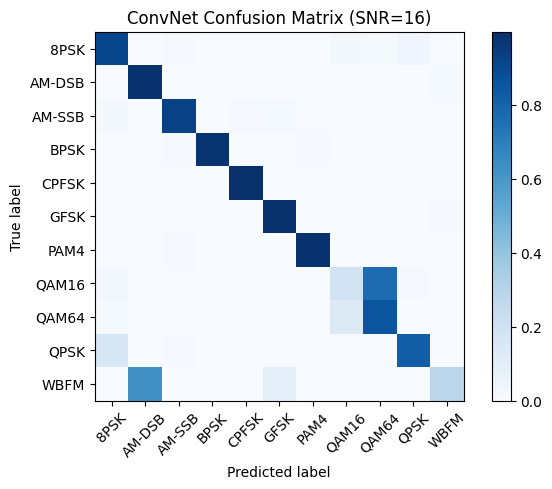

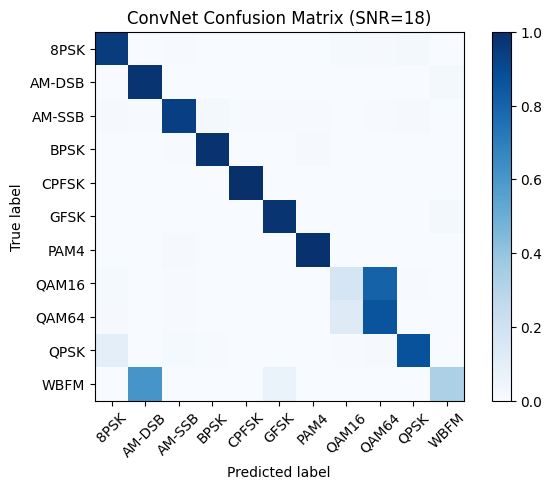

In [34]:
acc = {}
for snr in snrs:
    # extract classes @ SNR
    test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
    test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]

    test_X_i_tesnsor = torch.tensor(test_X_i).float().to(device).view(-1, 1, *in_shp)

    # estimate classes
    test_Y_i_hat = model(test_X_i_tesnsor).cpu().detach().numpy()

    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))

    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print (f'SNR: {snr}, Overall Accuracy: {cor * 100.0 / (cor+ncor)}%')
    acc[snr] = 1.0*cor/(cor+ncor)

Text(0.5, 1.0, 'CNN2 Classification Accuracy on RadioML 2016.10 Alpha')

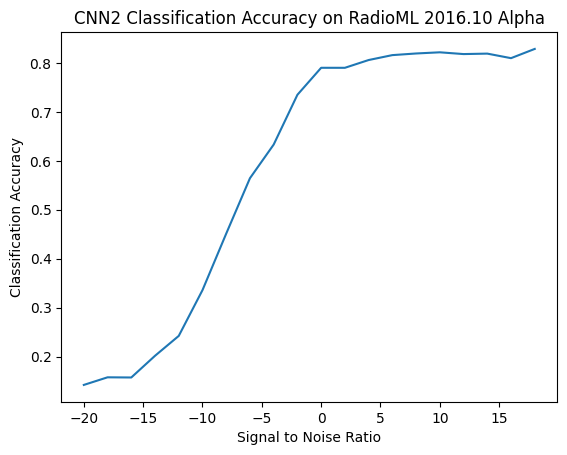

In [32]:
# Plot accuracy curve
plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha")